# STATS 201 Projection Notebook

## Life Expectancy Projections to 2030

This notebook extends the project by projecting national life expectancy for **2022–2030** using
the best model identified in `train_models.ipynb`:
**Random Forest (300 trees, max\_depth=15) with log-enhanced features** (Test R² = 0.9885).

**Workflow:**
1. Re-train the best model on the 2000–2017 training split.
2. Per country, extrapolate the 12 predictor features from 2021 using linear trends fitted on 2015–2021.
3. Generate **Baseline**, **Optimistic**, and **Pessimistic** scenario projections.
4. Quantify model uncertainty via Random Forest tree-level variance (80% interval).
5. Visualise global trends, country examples, the 2030 distribution, and top movers.
6. Export country-year projections to `cleaner_exports/` and figures to `Images/`.

> **Note:** This is a *predictive* extrapolation — not a causal forecast.
> All projections assume continuity of 2015–2021 structural trends and carry the same limitations
> as the underlying Random Forest model.

## 1) Imports and Project Paths

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as TrendLR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42

# Projection settings
PROJECTION_YEARS = list(range(2022, 2031))   # 2022 – 2030 inclusive
TREND_WINDOW     = 7                          # years of history to fit per-feature trends (2015-2021)

# Paths — relative to this notebook in Codes/
DATA_DIR = Path('../Assets/cleaner_exports')
IMG_DIR  = Path('../Images')
IMG_DIR.mkdir(parents=True, exist_ok=True)

FULL_PATH  = DATA_DIR / 'health_panel_ml_numeric.csv'
TRAIN_PATH = DATA_DIR / 'train_temporal_2000_2017.csv'
TEST_PATH  = DATA_DIR / 'test_temporal_2018_2021.csv'
MODEL_PATH = DATA_DIR / 'final_model_temporal.joblib'

for p in [FULL_PATH, TRAIN_PATH, TEST_PATH]:
    if not p.exists():
        raise FileNotFoundError(f'Missing required file: {p.resolve()}')

print('Data directory :', DATA_DIR.resolve())
print('Images directory:', IMG_DIR.resolve())
print('Projection years:', PROJECTION_YEARS[0], '–', PROJECTION_YEARS[-1])

Data directory : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports
Images directory: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images
Projection years: 2022 – 2030


## 2) Load Data and Re-Train Best Model

In [2]:
TARGET_COL = 'life_expectancy'

LOG_ENHANCED_FEATURES = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'log_infant_deaths',
    'u5_mortality_rate',
]

full_df  = pd.read_csv(FULL_PATH)
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(f'Full data : {full_df.shape}   | Years {int(full_df.Year.min())}–{int(full_df.Year.max())}')
print(f'Train     : {train_df.shape}  | Years {int(train_df.Year.min())}–{int(train_df.Year.max())}')
print(f'Test      : {test_df.shape}   | Years {int(test_df.Year.min())}–{int(test_df.Year.max())}')

# Fit preprocessing pipeline on training data (identical to train_models.ipynb)
X_train_raw = train_df[LOG_ENHANCED_FEATURES].copy()
X_test_raw  = test_df[LOG_ENHANCED_FEATURES].copy()
y_train     = train_df[TARGET_COL].values
y_test      = test_df[TARGET_COL].values

imp = SimpleImputer(strategy='median')
scl = StandardScaler()
X_train_scaled = scl.fit_transform(imp.fit_transform(X_train_raw))
X_test_scaled  = scl.transform(imp.transform(X_test_raw))

# Load saved model artifact or re-train from scratch
if MODEL_PATH.exists():
    try:
        rf = joblib.load(MODEL_PATH)
        _  = rf.predict(X_train_scaled[:1])   # sanity check
        print(f'Loaded saved model from: {MODEL_PATH.name}')
    except Exception as exc:
        print(f'Could not load saved model ({exc}). Re-training ...')
        rf = RandomForestRegressor(n_estimators=300, max_depth=15,
                                   random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_train_scaled, y_train)
else:
    print('Saved model not found. Training Random Forest (300 trees) ...')
    rf = RandomForestRegressor(n_estimators=300, max_depth=15,
                               random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)

# Verify performance on temporal test split
y_pred_test = rf.predict(X_test_scaled)
print(f'\nTest-set performance (2018–2021):')
print(f'  R²   : {r2_score(y_test, y_pred_test):.4f}')
print(f'  RMSE : {np.sqrt(mean_squared_error(y_test, y_pred_test)):.3f} yrs')
print(f'  MAE  : {mean_absolute_error(y_test, y_pred_test):.3f} yrs')

Full data : (4224, 19)   | Years 2000–2021
Train     : (3456, 19)  | Years 2000–2017
Test      : (768, 19)   | Years 2018–2021
Could not load saved model ('dict' object has no attribute 'predict'). Re-training ...

Test-set performance (2018–2021):
  R²   : 0.9885
  RMSE : 0.754 yrs
  MAE  : 0.522 yrs


## 3) Helper Functions for Trend Extrapolation and Scenario Adjustment

In [3]:
# Features where a *decreasing* trend is beneficial (lower = healthier)
NEGATIVE_GOOD = {
    'adult_mortality_15_60',
    'u5_mortality_rate',
    'log_infant_deaths',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
}

# Features where an *increasing* trend is beneficial (higher = healthier)
POSITIVE_GOOD = {
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'hepb3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'che_pct_gdp',
}

# Scenario multipliers applied to the *beneficial direction* of each feature's slope
SCENARIO_CONFIG = {
    'optimistic':  {'improve_mult': 1.50, 'worsen_mult': 0.50},
    'baseline':    {'improve_mult': 1.00, 'worsen_mult': 1.00},
    'pessimistic': {'improve_mult': 0.50, 'worsen_mult': 1.50},
}


def adjust_slope(slope: float, feature: str, scenario: str) -> float:
    """Scale a per-country per-feature trend slope according to scenario.

    For health-improving features:
      - Optimistic  → beneficial trends are amplified, worsening trends are dampened.
      - Pessimistic → beneficial trends are dampened, worsening trends are amplified.
    Neutral features (alcohol, overweight) keep the baseline slope unchanged.
    """
    cfg = SCENARIO_CONFIG[scenario]
    if feature in NEGATIVE_GOOD:
        # Beneficial if slope ≤ 0 (declining mortality / malnutrition)
        return slope * cfg['improve_mult'] if slope <= 0 else slope * cfg['worsen_mult']
    elif feature in POSITIVE_GOOD:
        # Beneficial if slope ≥ 0 (rising coverage / GDP)
        return slope * cfg['improve_mult'] if slope >= 0 else slope * cfg['worsen_mult']
    else:
        # Neutral — alcohol and overweight direction is ambiguous; keep baseline
        return slope


def extrapolate_scenario(
    full_df: pd.DataFrame,
    features: list,
    projection_years: list,
    trend_window: int = 7,
    scenario: str = 'baseline',
    feature_bounds: dict = None,
) -> pd.DataFrame:
    """Per country, fit a linear trend on the last `trend_window` years and project forward.

    All scenarios anchor to the 2021 observed value; slopes are adjusted per scenario.
    Projected values are clipped to `feature_bounds` to prevent extrapolation artefacts.

    Returns
    -------
    pd.DataFrame with columns: Country, ISO3, Year, Scenario, <feature columns>
    """
    max_hist_year = int(full_df['Year'].max())   # 2021
    trend_start   = max_hist_year - trend_window + 1  # 2015

    records = []

    for country, grp in full_df.groupby('Country'):
        grp    = grp.sort_values('Year')
        recent = grp[grp['Year'] >= trend_start]

        if len(recent) < 2:
            continue

        iso3    = grp['ISO3'].iloc[-1] if 'ISO3' in grp.columns else ''
        last_yr = grp.iloc[-1]   # most recent observed row (2021)

        # Fit a per-feature linear trend on the trend window
        slopes = {}
        anchors = {}
        for feat in features:
            vals  = recent[feat].values
            years = recent['Year'].values.reshape(-1, 1)
            valid = ~np.isnan(vals)

            if valid.sum() >= 2:
                lr  = TrendLR()
                lr.fit(years[valid], vals[valid])
                raw_slope   = lr.coef_[0]
                slopes[feat] = adjust_slope(raw_slope, feat, scenario)
            else:
                slopes[feat] = 0.0

            # Anchor: use 2021 value; fall back to last non-NaN
            anchor_val = last_yr[feat]
            if np.isnan(anchor_val):
                non_nan = grp[feat].dropna()
                anchor_val = non_nan.iloc[-1] if not non_nan.empty else np.nan
            anchors[feat] = anchor_val

        # Project: value at year yr = anchor_2021 + slope * (yr - 2021)
        for yr in projection_years:
            row = {'Country': country, 'ISO3': iso3, 'Year': yr, 'Scenario': scenario}
            for feat in features:
                if np.isnan(anchors[feat]):
                    row[feat] = np.nan
                    continue
                val = anchors[feat] + slopes[feat] * (yr - max_hist_year)
                if feature_bounds and feat in feature_bounds:
                    lo, hi = feature_bounds[feat]
                    val = float(np.clip(val, lo, hi))
                row[feat] = val
            records.append(row)

    return pd.DataFrame(records)


def preprocess_features(df: pd.DataFrame, features: list,
                         imp: SimpleImputer, scl: StandardScaler) -> np.ndarray:
    """Apply the fitted imputer and scaler to a feature dataframe."""
    X_raw = df[features].copy().values
    return scl.transform(imp.transform(X_raw))


def predict_with_uncertainty(
    rf: RandomForestRegressor, X_scaled: np.ndarray, percentile: int = 80
) -> tuple:
    """Return (mean, lower, upper) predictions using individual tree outputs.

    The interval covers `percentile`% of the tree-level distribution, providing
    a measure of model (epistemic) uncertainty — not a true frequentist interval.
    """
    tree_preds = np.array([tree.predict(X_scaled) for tree in rf.estimators_])
    half       = (100 - percentile) / 2
    return (
        tree_preds.mean(axis=0),
        np.percentile(tree_preds, half,           axis=0),
        np.percentile(tree_preds, 100 - half,     axis=0),
    )


print('Helper functions defined.')

Helper functions defined.


## 4) Feature Trend Extrapolation (2022–2030)

For each of the 192 countries, a linear trend is fitted on the **2015–2021 window** for each of the
12 predictor features. All scenarios anchor to the **2021 observed value** and diverge based on
adjusted slopes:

| Scenario | Beneficial trend | Worsening trend |
|---|---|---|
| Optimistic | 1.5× faster | 0.5× dampened |
| Baseline | As observed | As observed |
| Pessimistic | 0.5× dampened | 1.5× amplified |

In [4]:
# Compute feature bounds from observed data (1st–99th percentile + 25% buffer)
feature_bounds = {}
for feat in LOG_ENHANCED_FEATURES:
    lo  = full_df[feat].quantile(0.01)
    hi  = full_df[feat].quantile(0.99)
    buf = (hi - lo) * 0.25
    feature_bounds[feat] = (max(0.0, lo - buf) if lo >= 0 else lo - buf, hi + buf)

# Hard physical bounds for percentage / coverage features
for pct_feat in ['hepb3_coverage_pct', 'pol3_coverage_pct', 'dtp3_coverage_pct',
                  'overweight_adults_pct', 'underweight_adults_pct',
                  'thinness_children_adolescents_pct']:
    feature_bounds[pct_feat] = (0.0, 99.0)
feature_bounds['alcohol_per_capita_15plus'] = (0.0, 25.0)
feature_bounds['adult_mortality_15_60']     = (10.0, 950.0)
feature_bounds['u5_mortality_rate']         = (0.5,  250.0)

print('Feature bounds:')
for feat, (lo, hi) in feature_bounds.items():
    print(f'  {feat:<40s}  [{lo:.2f}, {hi:.2f}]')

# Run extrapolation for all three scenarios
SCENARIOS = ['baseline', 'optimistic', 'pessimistic']

scenario_feature_dfs = {}
for sc in SCENARIOS:
    df_sc = extrapolate_scenario(
        full_df, LOG_ENHANCED_FEATURES, PROJECTION_YEARS,
        trend_window=TREND_WINDOW, scenario=sc, feature_bounds=feature_bounds,
    )
    scenario_feature_dfs[sc] = df_sc
    print(f'{sc:12s}: {len(df_sc):5d} rows  ({df_sc["Country"].nunique()} countries × {len(PROJECTION_YEARS)} years)')

Feature bounds:
  adult_mortality_15_60                     [10.00, 950.00]
  alcohol_per_capita_15plus                 [0.00, 25.00]
  che_pct_gdp                               [0.00, 21.49]
  hepb3_coverage_pct                        [0.00, 99.00]
  pol3_coverage_pct                         [0.00, 99.00]
  dtp3_coverage_pct                         [0.00, 99.00]
  log_gdp_per_capita_2015usd                [4.39, 12.63]
  overweight_adults_pct                     [0.00, 99.00]
  underweight_adults_pct                    [0.00, 99.00]
  thinness_children_adolescents_pct         [0.00, 99.00]
  log_infant_deaths                         [0.00, 16.02]
  u5_mortality_rate                         [0.50, 250.00]
baseline    :  1728 rows  (192 countries × 9 years)
optimistic  :  1728 rows  (192 countries × 9 years)
pessimistic :  1728 rows  (192 countries × 9 years)


## 5) Predictions with Uncertainty Quantification

In [5]:
scenario_preds = {}

for sc in SCENARIOS:
    df_sc  = scenario_feature_dfs[sc].copy()
    X_proj = preprocess_features(df_sc, LOG_ENHANCED_FEATURES, imp, scl)

    if sc == 'baseline':
        # Baseline: full tree-level uncertainty (80% interval)
        mean_pred, lo_pred, hi_pred = predict_with_uncertainty(rf, X_proj, percentile=80)
        df_sc['life_expectancy_proj']      = mean_pred
        df_sc['life_expectancy_proj_lo80'] = lo_pred
        df_sc['life_expectancy_proj_hi80'] = hi_pred
    else:
        # Optimistic / pessimistic: mean prediction only
        df_sc['life_expectancy_proj'] = rf.predict(X_proj)

    scenario_preds[sc] = df_sc
    mean_2030 = df_sc[df_sc['Year'] == 2030]['life_expectancy_proj'].mean()
    print(f'{sc:12s}: global mean projected LE in 2030 = {mean_2030:.2f} yrs')

# Also assemble test-period model predictions for plotting continuity
test_pred_df = test_df[['Country', 'Year', TARGET_COL]].copy()
test_pred_df['pred_le'] = y_pred_test
print('\nTest-period prediction rows:', len(test_pred_df))

baseline    : global mean projected LE in 2030 = 71.70 yrs
optimistic  : global mean projected LE in 2030 = 72.57 yrs
pessimistic : global mean projected LE in 2030 = 70.81 yrs

Test-period prediction rows: 768


## 6) Visualisations

### 6a) Global Mean Life Expectancy: Historical Trend and 2022–2030 Projections

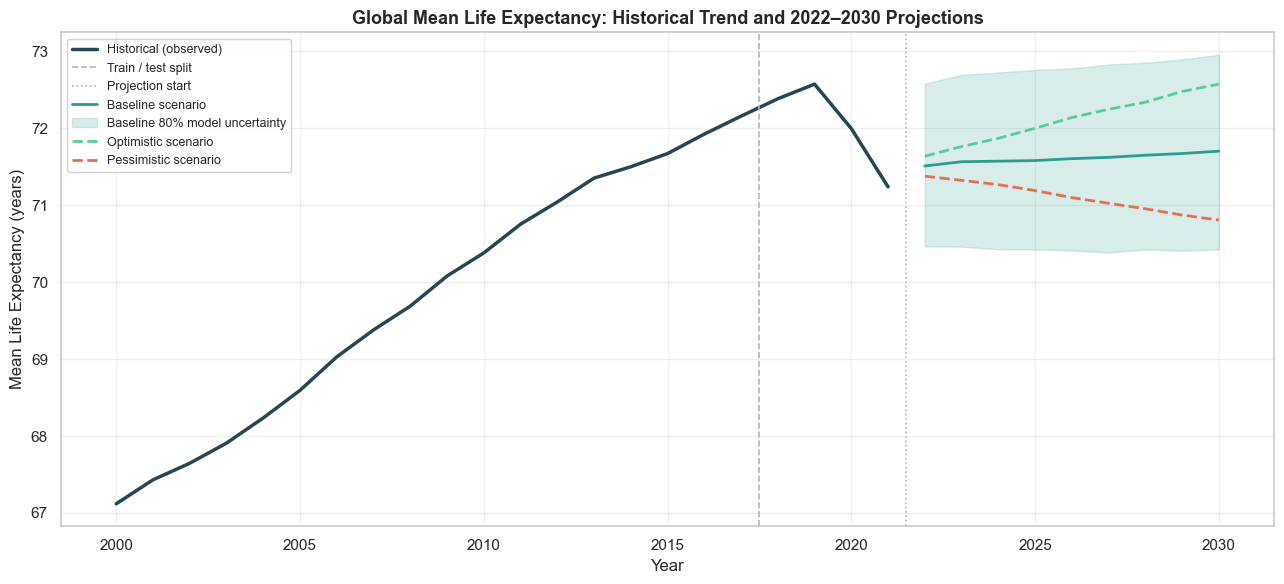

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/projection_global_trend.png


In [6]:
# Prepare global mean series
hist_mean  = full_df.groupby('Year')[TARGET_COL].mean().reset_index(name='mean_le')
test_mean  = test_pred_df.groupby('Year')['pred_le'].mean().reset_index(name='mean_le')

# Projection means
COLORS = {'baseline': '#2a9d8f', 'optimistic': '#57cc99', 'pessimistic': '#e76f51'}
LABELS = {'baseline': 'Baseline',  'optimistic': 'Optimistic', 'pessimistic': 'Pessimistic'}

proj_means = {}
for sc in SCENARIOS:
    grp = scenario_preds[sc].groupby('Year')['life_expectancy_proj'].mean().reset_index(name='mean_le')
    if sc == 'baseline':
        grp['lo80'] = scenario_preds[sc].groupby('Year')['life_expectancy_proj_lo80'].mean().values
        grp['hi80'] = scenario_preds[sc].groupby('Year')['life_expectancy_proj_hi80'].mean().values
    proj_means[sc] = grp

fig, ax = plt.subplots(figsize=(13, 6))

# Historical observed
ax.plot(hist_mean['Year'], hist_mean['mean_le'],
        color='#264653', lw=2.5, label='Historical (observed)')

# Dividers
ax.axvline(2017.5, color='#adb5bd', ls='--', lw=1.2, label='Train / test split')
ax.axvline(2021.5, color='#adb5bd', ls=':',  lw=1.2, label='Projection start')

# Scenario projections
for sc in SCENARIOS:
    grp = proj_means[sc]
    ls  = '-' if sc == 'baseline' else '--'
    ax.plot(grp['Year'], grp['mean_le'],
            color=COLORS[sc], lw=2.0, ls=ls, label=f'{LABELS[sc]} scenario')
    if sc == 'baseline':
        ax.fill_between(grp['Year'], grp['lo80'], grp['hi80'],
                        alpha=0.18, color=COLORS[sc],
                        label='Baseline 80% model uncertainty')

ax.set_title('Global Mean Life Expectancy: Historical Trend and 2022–2030 Projections',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Life Expectancy (years)')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()

out_fig = IMG_DIR / 'projection_global_trend.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())

### 6b) Selected Country Projections

Selected countries: ['Japan', 'Germany', 'Brazil', 'India', 'Nigeria', 'United States']


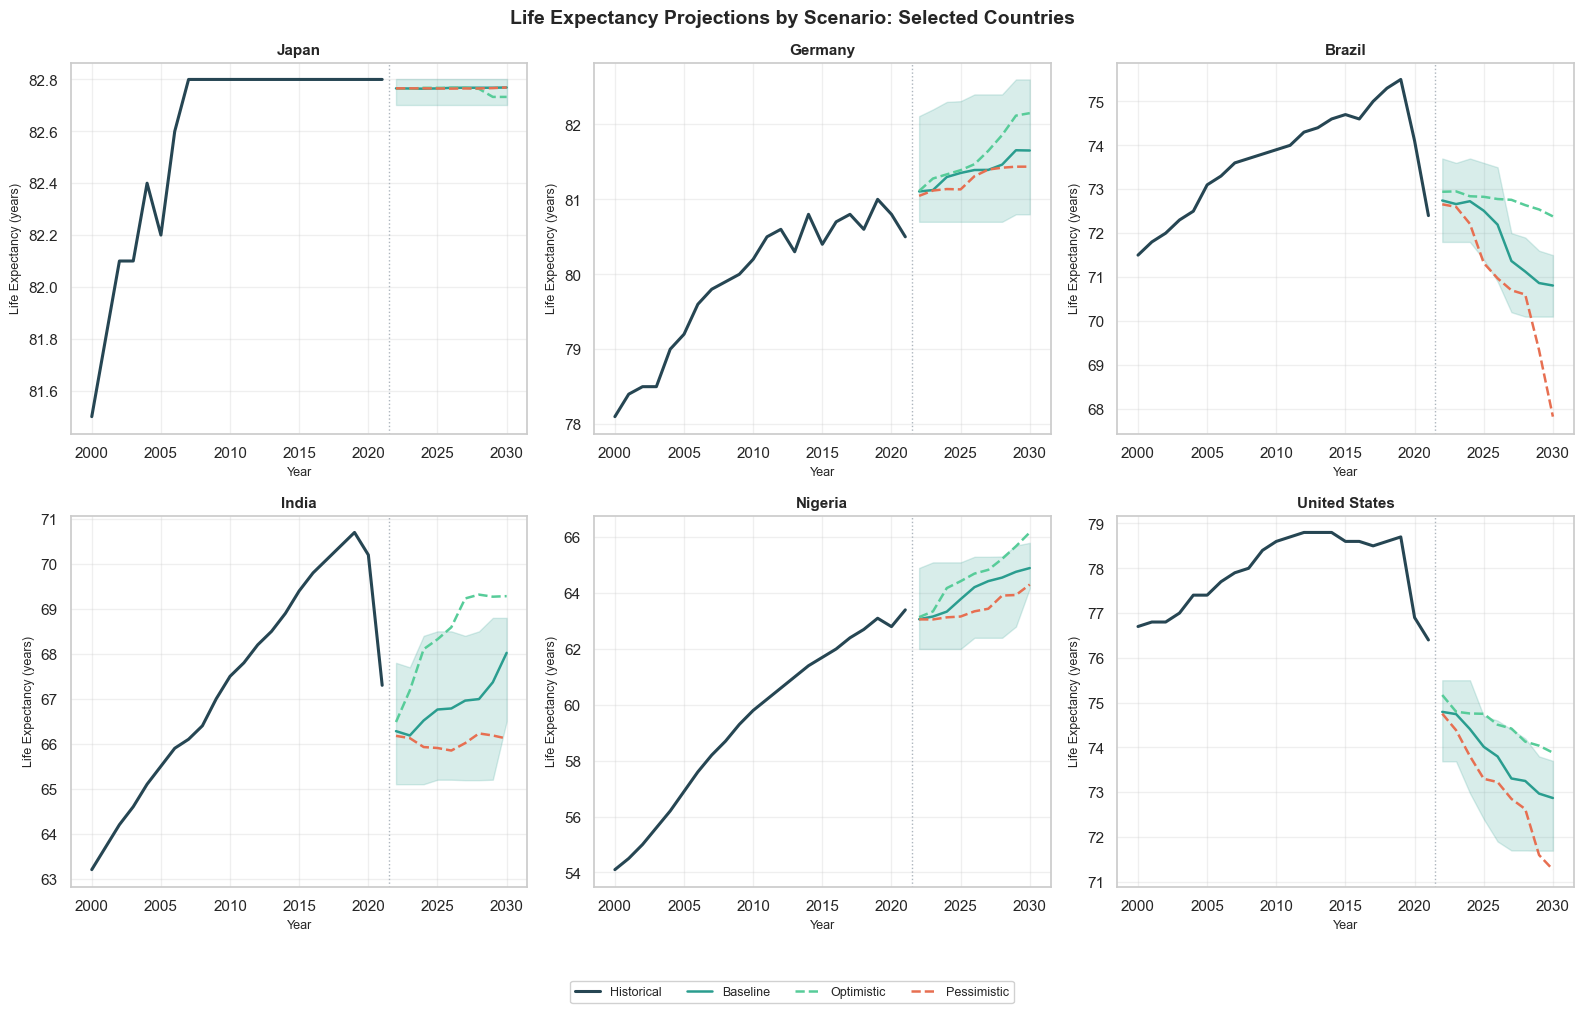

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/projection_country_examples.png


In [7]:
# Select diverse example countries; fall back to available names if needed
CANDIDATE_COUNTRIES = [
    'Japan', 'Germany', 'United States of America', 'Brazil', 'India', 'Nigeria',
    'United States', 'China',
]
available = set(full_df['Country'].unique())
EXAMPLE_COUNTRIES = [c for c in CANDIDATE_COUNTRIES if c in available][:6]

if len(EXAMPLE_COUNTRIES) < 6:
    # Fill remaining slots from dataset
    extras = [c for c in available if c not in EXAMPLE_COUNTRIES]
    EXAMPLE_COUNTRIES += extras[:6 - len(EXAMPLE_COUNTRIES)]

print('Selected countries:', EXAMPLE_COUNTRIES)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, country in enumerate(EXAMPLE_COUNTRIES):
    ax   = axes[i]
    hist = full_df[full_df['Country'] == country].sort_values('Year')

    if hist.empty:
        ax.set_title(f'{country}\n(no data)', fontsize=10)
        continue

    # Historical
    ax.plot(hist['Year'], hist[TARGET_COL],
            color='#264653', lw=2.2, label='Historical' if i == 0 else None)

    # Projection start marker
    ax.axvline(2021.5, color='#adb5bd', ls=':', lw=1.0)

    # Scenario projections
    for sc in SCENARIOS:
        proj = (
            scenario_preds[sc][scenario_preds[sc]['Country'] == country]
            .sort_values('Year')
        )
        if proj.empty:
            continue

        ls = '-' if sc == 'baseline' else '--'
        ax.plot(proj['Year'], proj['life_expectancy_proj'],
                color=COLORS[sc], lw=1.8, ls=ls,
                label=LABELS[sc] if i == 0 else None)

        if sc == 'baseline' and 'life_expectancy_proj_lo80' in proj.columns:
            ax.fill_between(
                proj['Year'],
                proj['life_expectancy_proj_lo80'],
                proj['life_expectancy_proj_hi80'],
                alpha=0.18, color=COLORS[sc],
            )

    ax.set_title(country, fontsize=11, fontweight='bold')
    ax.set_xlabel('Year', fontsize=9)
    ax.set_ylabel('Life Expectancy (years)', fontsize=9)
    ax.grid(alpha=0.3)

# Shared legend below figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=9,
           bbox_to_anchor=(0.5, -0.02), framealpha=0.9)

fig.suptitle('Life Expectancy Projections by Scenario: Selected Countries',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.04, 1, 1])

out_fig = IMG_DIR / 'projection_country_examples.png'
plt.savefig(out_fig, dpi=180, bbox_inches='tight')
plt.show()
print('Saved:', out_fig.resolve())

### 6c) Projected Life Expectancy Distribution in 2030

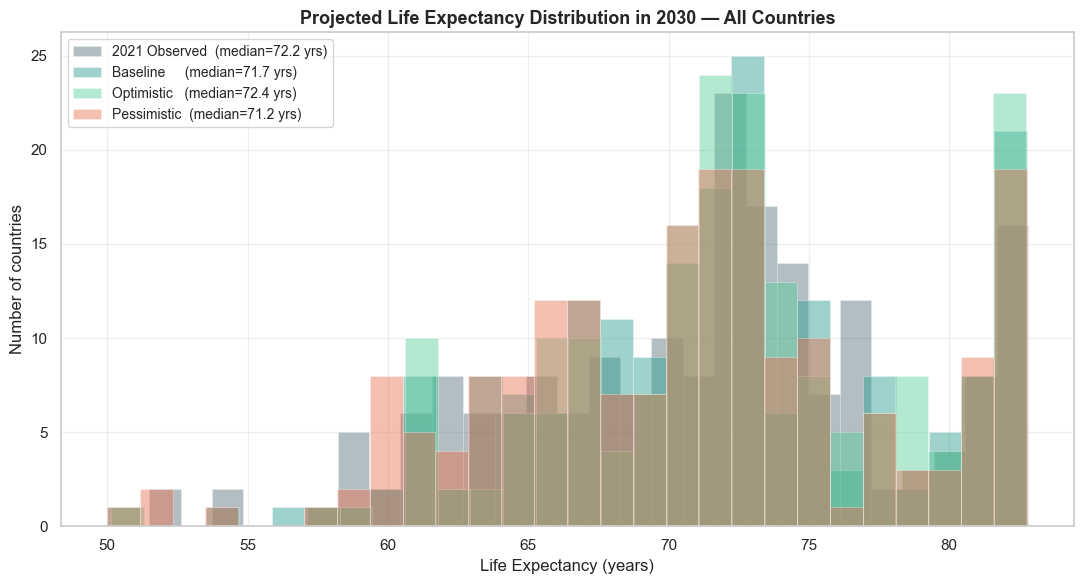

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/projection_distribution_2030.png


In [8]:
fig, ax = plt.subplots(figsize=(11, 6))

# Also show 2021 observed distribution for reference
le_2021 = full_df[full_df['Year'] == 2021][TARGET_COL].dropna()
ax.hist(le_2021, bins=28, alpha=0.35, color='#264653', edgecolor='white', lw=0.5,
        label=f'2021 Observed  (median={le_2021.median():.1f} yrs)')

for sc in SCENARIOS:
    vals   = scenario_preds[sc][scenario_preds[sc]['Year'] == 2030]['life_expectancy_proj'].dropna()
    median = vals.median()
    ax.hist(vals, bins=28, alpha=0.45, color=COLORS[sc], edgecolor='white', lw=0.5,
            label=f'{LABELS[sc]:12s} (median={median:.1f} yrs)')

ax.set_title('Projected Life Expectancy Distribution in 2030 — All Countries',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Life Expectancy (years)')
ax.set_ylabel('Number of countries')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()

out_fig = IMG_DIR / 'projection_distribution_2030.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())

### 6d) Top Projected Movers (Baseline, 2021 → 2030)

Countries with positive projected change: 105
Countries with negative projected change: 87


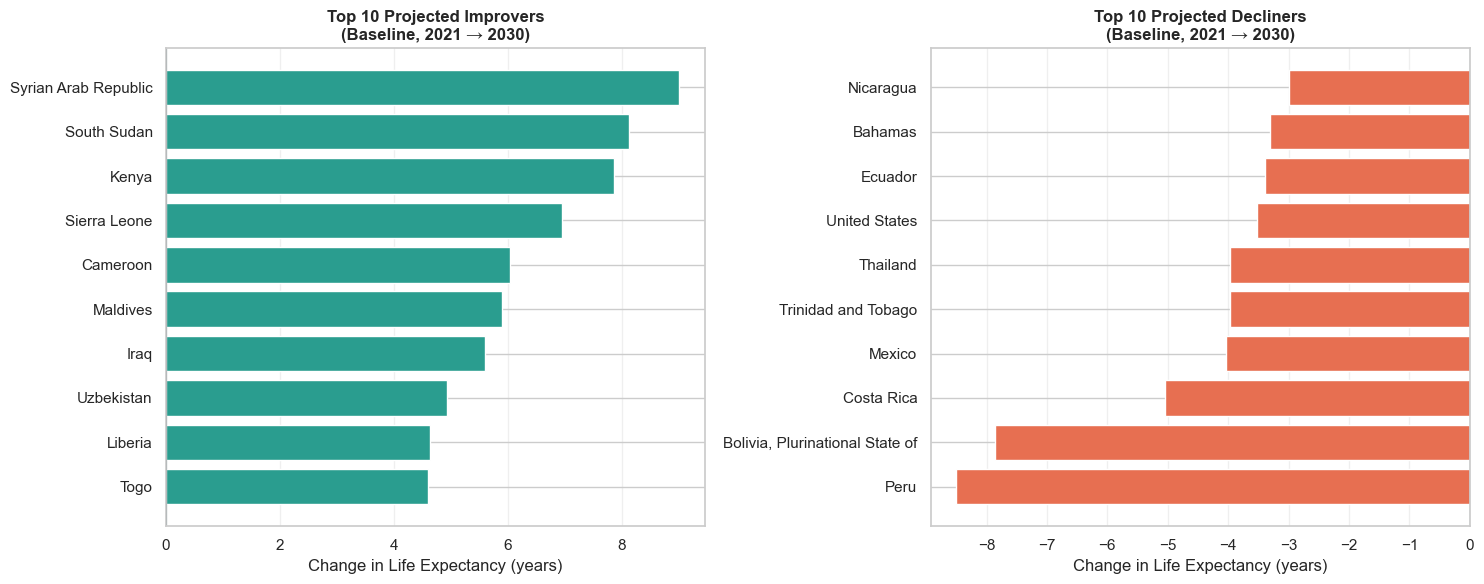

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/projection_top_movers.png


In [9]:
# Merge 2021 observed LE with baseline 2030 projection
le_obs_2021 = (
    full_df[full_df['Year'] == 2021][['Country', TARGET_COL]]
    .rename(columns={TARGET_COL: 'le_2021'})
)
le_proj_2030 = (
    scenario_preds['baseline'][scenario_preds['baseline']['Year'] == 2030]
    [['Country', 'life_expectancy_proj']]
    .rename(columns={'life_expectancy_proj': 'le_2030'})
)

movers = le_obs_2021.merge(le_proj_2030, on='Country').dropna()
movers['change'] = movers['le_2030'] - movers['le_2021']
movers = movers.sort_values('change', ascending=False).reset_index(drop=True)

top_improvers = movers.head(10)
top_decliners = movers.tail(10).sort_values('change')

print(f'Countries with positive projected change: {(movers["change"] > 0).sum()}')
print(f'Countries with negative projected change: {(movers["change"] < 0).sum()}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top improvers
ax1.barh(top_improvers['Country'][::-1], top_improvers['change'][::-1],
         color='#2a9d8f', edgecolor='white')
ax1.set_title('Top 10 Projected Improvers\n(Baseline, 2021 → 2030)', fontweight='bold')
ax1.set_xlabel('Change in Life Expectancy (years)')
ax1.axvline(0, color='#264653', lw=0.8)
ax1.grid(alpha=0.3, axis='x')

# Top decliners
ax2.barh(top_decliners['Country'], top_decliners['change'],
         color='#e76f51', edgecolor='white')
ax2.set_title('Top 10 Projected Decliners\n(Baseline, 2021 → 2030)', fontweight='bold')
ax2.set_xlabel('Change in Life Expectancy (years)')
ax2.axvline(0, color='#264653', lw=0.8)
ax2.grid(alpha=0.3, axis='x')

plt.tight_layout()
out_fig = IMG_DIR / 'projection_top_movers.png'
plt.savefig(out_fig, dpi=180)
plt.show()
print('Saved:', out_fig.resolve())

## 7) Export Results

In [10]:
# Export 1 — Baseline projections (all years, with 80% interval)
baseline_export = (
    scenario_preds['baseline']
    [['Country', 'ISO3', 'Year',
      'life_expectancy_proj',
      'life_expectancy_proj_lo80',
      'life_expectancy_proj_hi80']]
    .rename(columns={
        'life_expectancy_proj':      'proj_le_baseline',
        'life_expectancy_proj_lo80': 'proj_le_lo80',
        'life_expectancy_proj_hi80': 'proj_le_hi80',
    })
    .sort_values(['Country', 'Year'])
    .reset_index(drop=True)
)
out1 = DATA_DIR / 'projection_baseline_2022_2030.csv'
baseline_export.to_csv(out1, index=False)
print('Saved:', out1.resolve(), f'  ({len(baseline_export)} rows)')

# Export 2 — All scenarios, 2030 snapshot
rows_2030 = []
for sc in SCENARIOS:
    df_sc = (
        scenario_preds[sc][scenario_preds[sc]['Year'] == 2030]
        [['Country', 'ISO3', 'life_expectancy_proj']]
        .assign(Scenario=sc)
        .rename(columns={'life_expectancy_proj': 'proj_le'})
    )
    rows_2030.append(df_sc)

proj_2030_all = pd.concat(rows_2030, ignore_index=True).sort_values(['Scenario', 'Country'])
out2 = DATA_DIR / 'projection_scenarios_2030.csv'
proj_2030_all.to_csv(out2, index=False)
print('Saved:', out2.resolve(), f'  ({len(proj_2030_all)} rows)')

# Export 3 — All scenarios, all projection years
rows_all = []
for sc in SCENARIOS:
    df_sc = (
        scenario_preds[sc][['Country', 'ISO3', 'Year', 'life_expectancy_proj']]
        .assign(Scenario=sc)
        .rename(columns={'life_expectancy_proj': 'proj_le'})
    )
    rows_all.append(df_sc)

proj_all = pd.concat(rows_all, ignore_index=True).sort_values(['Scenario', 'Country', 'Year'])
out3 = DATA_DIR / 'projection_all_scenarios_2022_2030.csv'
proj_all.to_csv(out3, index=False)
print('Saved:', out3.resolve(), f'  ({len(proj_all)} rows)')

# Export 4 — Top movers summary
out4 = DATA_DIR / 'projection_movers_baseline.csv'
movers.to_csv(out4, index=False)
print('Saved:', out4.resolve(), f'  ({len(movers)} rows)')

print('\nAll exports complete.')

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/projection_baseline_2022_2030.csv   (1728 rows)
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/projection_scenarios_2030.csv   (576 rows)
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/projection_all_scenarios_2022_2030.csv   (5184 rows)
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/projection_movers_baseline.csv   (192 rows)

All exports complete.


## 8) Limitations and Scope

- **Trend extrapolation is linear.** Country-feature trends are approximated by a linear regression
  on 2015–2021. Non-linear dynamics (e.g., saturation of vaccine coverage at 99%, convergence
  of low-income mortality rates) are not captured.

- **Model uncertainty ≠ full predictive uncertainty.** The 80% tree-level interval reflects
  model (epistemic) uncertainty only. It does not account for feature-extrapolation error,
  distribution shift, or structural breaks (e.g., COVID-like shocks).

- **Random Forest is an interpolative model.** Its predictions outside the training distribution
  (e.g., feature values exceeding 2021 levels) are extrapolations and may be unreliable.

- **Scenario design is heuristic.** The 50% slope multipliers for optimistic/pessimistic scenarios
  are illustrative, not calibrated to historical policy interventions.

- **No explicit COVID-19 modelling.** The 2020–2021 dip and subsequent rebound dynamics may
  not be correctly extrapolated by a linear trend over 2015–2021.

- **National-level aggregates.** All projections are country means; within-country inequality
  and subnational variation are not represented.

**Recommended use:** These projections are best interpreted as *scenarios for discussion*, not
precise forecasts. Treat the baseline 80% interval as a rough guide to model sensitivity rather
than a rigorous confidence band.